### This notebook walks you through how to create a searchable PDF using Azure OCR & pymupdf


In [1]:
# fetch a file from the internet or use your own
!wget -O 1998-05-15_0057.pdf https://www.ejustice.just.fgov.be/tsv_pdf/1998/05/15/1998-05-15_0057.pdf

--2024-06-24 14:56:44--  https://www.ejustice.just.fgov.be/tsv_pdf/1998/05/15/1998-05-15_0057.pdf
Resolving www.ejustice.just.fgov.be (www.ejustice.just.fgov.be)... 193.191.241.68
Connecting to www.ejustice.just.fgov.be (www.ejustice.just.fgov.be)|193.191.241.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112308 (110K) [application/pdf]
Saving to: ‘1998-05-15_0057.pdf’

1998-05-15_0057.pdf 100%[===================>] 109.68K  --.-KB/s    in 0.02s   

2024-06-24 14:56:44 (6.21 MB/s) - ‘1998-05-15_0057.pdf’ saved [112308/112308]



In [2]:
import os
import io

import pymupdf
from PIL import Image
from dotenv import load_dotenv
from azure.ai.formrecognizer import DocumentAnalysisClient
from azure.core.credentials import AzureKeyCredential

In [3]:
load_dotenv()
endpoint = os.environ["AZURE_DOCUMENT_INTELLIGENCE_URL"]
key = os.environ["AZURE_DOCUMENT_INTELLIGENCE_KEY"]

#### Load in pdf, once using pymupdf, once in bytes to send to Azure

In [4]:
pdf_file = "1998-05-15_0057.pdf"
pdf = pymupdf.open(pdf_file)
bytes = open(pdf_file, "rb").read()

#### OCR the pdf using Azure

In [5]:
di_client = DocumentAnalysisClient(endpoint=endpoint, credential=AzureKeyCredential(key))

In [6]:
poller = di_client.begin_analyze_document(model_id="prebuilt-read", document=bytes)
result = poller.result()

#### Overlay the text on the PDF (making it searchable)

In [7]:
fontname = "helv"
font = pymupdf.Font(fontname)
for pdf_page, ocr_page in zip(pdf, result.pages):
    # Calculate scaling factors
    scale_x = pdf_page.rect.width / ocr_page.width
    scale_y = pdf_page.rect.height / ocr_page.height
    matrix = pymupdf.Rect(0, 0, 1, 1).torect(pdf_page.rect)

    for word in ocr_page.words:
        # ocr results are in relative coordinates, convert to absolute
        points = [pymupdf.Point(point.x * scale_x, point.y * scale_y) for point in word.polygon]
        # Create a rectangle from the transformed points
        bbox_mupdf = pymupdf.Rect(points[0], points[2])

        # Font selection and text length calculation
        tl = font.text_length(word.content, fontsize=1)
        fontsize = bbox_mupdf.width / tl

        # Determine if text contains descenders
        descender_chars = "gjpqy"
        contains_descenders = any(char in word.content for char in descender_chars)

        # Determine insertion point
        # if contains_descenders:
        insertion_point = bbox_mupdf.bl + (0, font.descender * fontsize)
        # else:
        # insertion_point = bbox_mupdf.bl
        # Insert text into the PDF with render_mode=3 (invisible text)
        pdf_page.insert_text(
            point=insertion_point,
            text=word.content,
            fontsize=fontsize,
            fontname=fontname,
            render_mode=0,  # Visible text for debugging, set to 3 for invisible
            color=(1, 0, 0),  # Red color for visibility
        )

#### Display the results

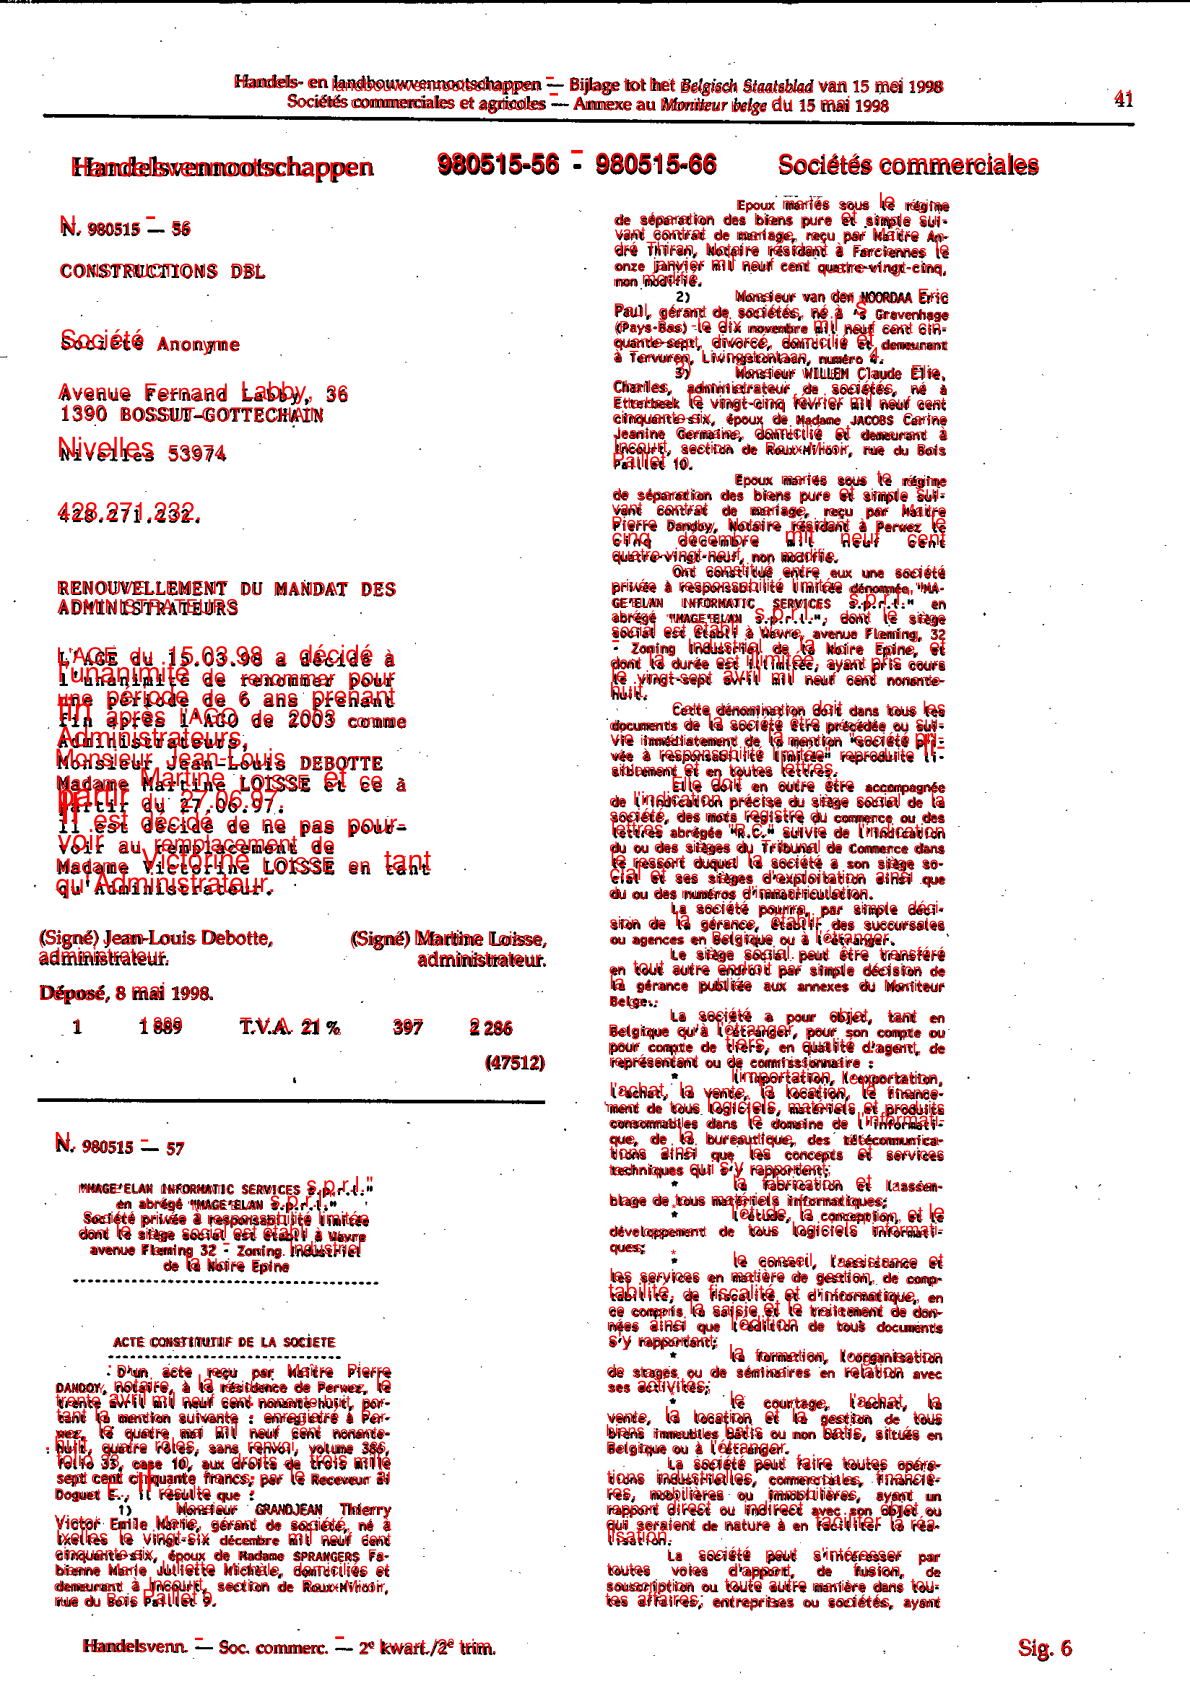

In [8]:
pix = pdf[0].get_pixmap(matrix=pymupdf.Matrix(2,2))
image = Image.open(io.BytesIO(pix.tobytes("png")))
image

#### Without the debugging red color.

In [9]:
pdf = pymupdf.open(pdf_file)
fontname = "helv"
font = pymupdf.Font(fontname)
for pdf_page, ocr_page in zip(pdf, result.pages):
    # Calculate scaling factors
    scale_x = pdf_page.rect.width / ocr_page.width
    scale_y = pdf_page.rect.height / ocr_page.height
    matrix = pymupdf.Rect(0, 0, 1, 1).torect(pdf_page.rect)

    for word in ocr_page.words:
        # ocr results are in relative coordinates, convert to absolute
        points = [pymupdf.Point(point.x * scale_x, point.y * scale_y) for point in word.polygon]
        # Create a rectangle from the transformed points
        bbox_mupdf = pymupdf.Rect(points[0], points[2])

        # Font selection and text length calculation
        tl = font.text_length(word.content, fontsize=1)
        fontsize = bbox_mupdf.width / tl

        # Determine if text contains descenders
        descender_chars = "gjpqy"
        contains_descenders = any(char in word.content for char in descender_chars)

        # Determine insertion point
        # if contains_descenders:
        insertion_point = bbox_mupdf.bl + (0, font.descender * fontsize)
        # else:
        # insertion_point = bbox_mupdf.bl
        # Insert text into the PDF with render_mode=3 (invisible text)
        pdf_page.insert_text(
            point=insertion_point,
            text=word.content,
            fontsize=fontsize,
            fontname=fontname,
            render_mode=3,  # Visible text for debugging, set to 3 for invisible
        )


Obviously displaying here won't show the change since the overlayed text is invisble...

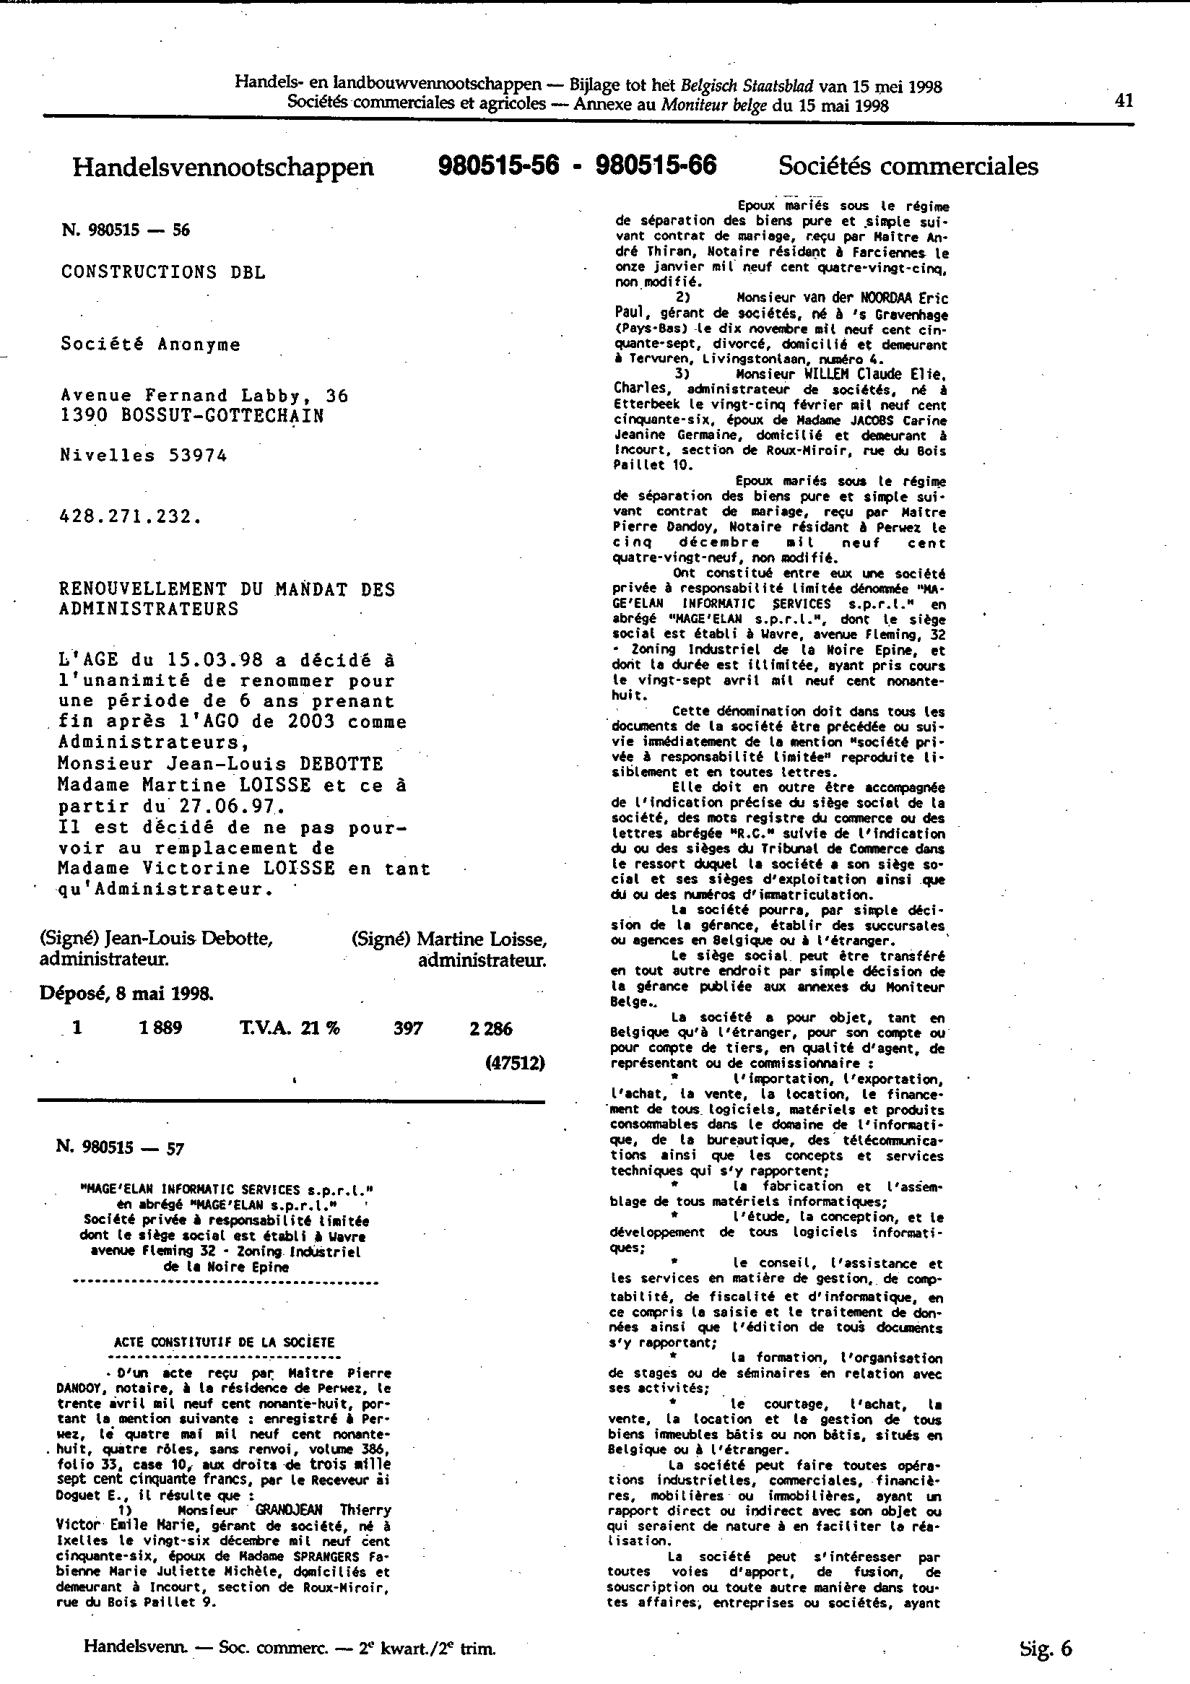

In [10]:
pix = pdf[0].get_pixmap(matrix=pymupdf.Matrix(2,2))
image = Image.open(io.BytesIO(pix.tobytes("png")))
image

In [11]:
pdf.save("searchable.pdf")